# B02b: Phase Relationships

**Part 2 of 2** | ⏱️ **Duration:** 35-45 minutes

## Prerequisites
- [B01: Hilbert Transform](../B01_hilbert_transform.ipynb) - Phase extraction
- [B02a: Circular Statistics](B02a_circular_statistics.ipynb) - Circular mean, variance, R

## Learning Objectives
By the end of this notebook, you will be able to:
1. Calculate phase difference between two signals
2. Understand instantaneous vs average phase relationships
3. Visualize phase coupling patterns
4. Connect phase relationships to synchronization measures (PLV preview)

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Phase Difference Between Signals](#section-2-phase-difference)
3. [Instantaneous vs Average Phase Difference](#section-3-instantaneous-vs-average)
4. [Visualizing Phase Relationships](#section-4-visualizing-relationships)
5. [Phase Locking: A Preview](#section-5-phase-locking-preview)
6. [Application: Two Coupled Oscillators](#section-6-application)
7. [Exercises](#section-7-exercises)
8. [Summary](#section-8-summary)
9. [External Resources](#section-9-external-resources)
10. [Discussion Questions](#section-10-discussion)

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
from typing import Optional, Tuple
import matplotlib.pyplot as plt
from scipy import signal

# ============================================================================
# PATH SETUP
# ============================================================================

# Add src/ to path for local imports
PROJECT_ROOT = Path.cwd().parents[2]
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

# ============================================================================
# LOCAL IMPORTS
# ============================================================================

from colors import COLORS

# ============================================================================
# MATPLOTLIB CONFIGURATION
# ============================================================================

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("✓ All imports successful")
print(f"✓ Project root: {PROJECT_ROOT}")

✓ All imports successful
✓ Project root: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials


---

<a id="section-1-introduction"></a>
## 1. Introduction

In [B02a](B02a_circular_statistics.ipynb), we learned how to work with phase values from a **single signal** using circular statistics. Now we take the crucial next step: comparing phases **between two signals**.

### Why Phase Relationships Matter

In hyperscanning and connectivity analysis, we're interested in how brain regions (or brains!) coordinate their activity. Phase relationships tell us:

- **Are two regions oscillating together?** (in-phase = 0° difference)
- **Are they oscillating in opposition?** (anti-phase = 180° difference)
- **Is there a consistent lag?** (constant non-zero difference)
- **How stable is the relationship?** (variable difference = no coupling)

### From Single Signal to Signal Pairs

| B02a: Single Signal | B02b: Signal Pairs |
|---------------------|-------------------|
| Phase of one signal | Phase **difference** between two |
| Circular mean of phases | **Average** phase difference |
| R = concentration of phases | R = **consistency** of phase difference |
| "How clustered are phases?" | "How coupled are the signals?" |

### The Key Insight

> **The same circular statistics we learned for single signals can be applied to phase differences to quantify synchronization.**

This is the foundation of **Phase Locking Value (PLV)**, which we'll explore in detail in [G01](../../02_connectivity_metrics/G_phase_based/G01_phase_locking_value.ipynb).

---

<a id="section-2-phase-difference"></a>
## 2. Phase Difference Between Signals

### Mathematical Definition

Given two signals with phases $\phi_1(t)$ and $\phi_2(t)$, the **instantaneous phase difference** is:

$$\Delta\phi(t) = \phi_1(t) - \phi_2(t)$$

### Important: Wrapping the Difference

Since we're subtracting two angles, the result must be wrapped to $[-\pi, \pi]$:

$$\Delta\phi_{wrapped}(t) = \arctan2(\sin(\Delta\phi), \cos(\Delta\phi))$$

Or equivalently using complex exponentials:

$$\Delta\phi_{wrapped}(t) = \angle(e^{i\phi_1} \cdot e^{-i\phi_2}) = \angle(e^{i(\phi_1 - \phi_2)})$$

### Interpretation of Phase Difference

| Phase Difference | Interpretation |
|------------------|----------------|
| $\Delta\phi = 0$ | In-phase (synchronized peaks) |
| $\Delta\phi = \pm\pi$ | Anti-phase (opposite peaks) |
| $\Delta\phi = \pi/2$ | Quadrature (90° lead) |
| $\Delta\phi = -\pi/2$ | Quadrature (90° lag) |

In [2]:
# ============================================================================
# FUNCTIONS: Phase Difference
# ============================================================================

def phase_difference(phase1: NDArray[np.float64], 
                     phase2: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Calculate wrapped phase difference between two phase time series.
    
    Parameters
    ----------
    phase1 : NDArray[np.float64]
        Phase of first signal in radians.
    phase2 : NDArray[np.float64]
        Phase of second signal in radians.
        
    Returns
    -------
    NDArray[np.float64]
        Wrapped phase difference in [-π, π].
    """
    diff = phase1 - phase2
    # Wrap to [-π, π] using complex exponential
    return np.angle(np.exp(1j * diff))


def extract_phase(sig: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Extract instantaneous phase using Hilbert transform.
    
    Parameters
    ----------
    sig : NDArray[np.float64]
        Input signal.
        
    Returns
    -------
    NDArray[np.float64]
        Instantaneous phase in radians [-π, π].
    """
    analytic = signal.hilbert(sig)
    return np.angle(analytic)


print("✓ phase_difference() and extract_phase() defined")

✓ phase_difference() and extract_phase() defined


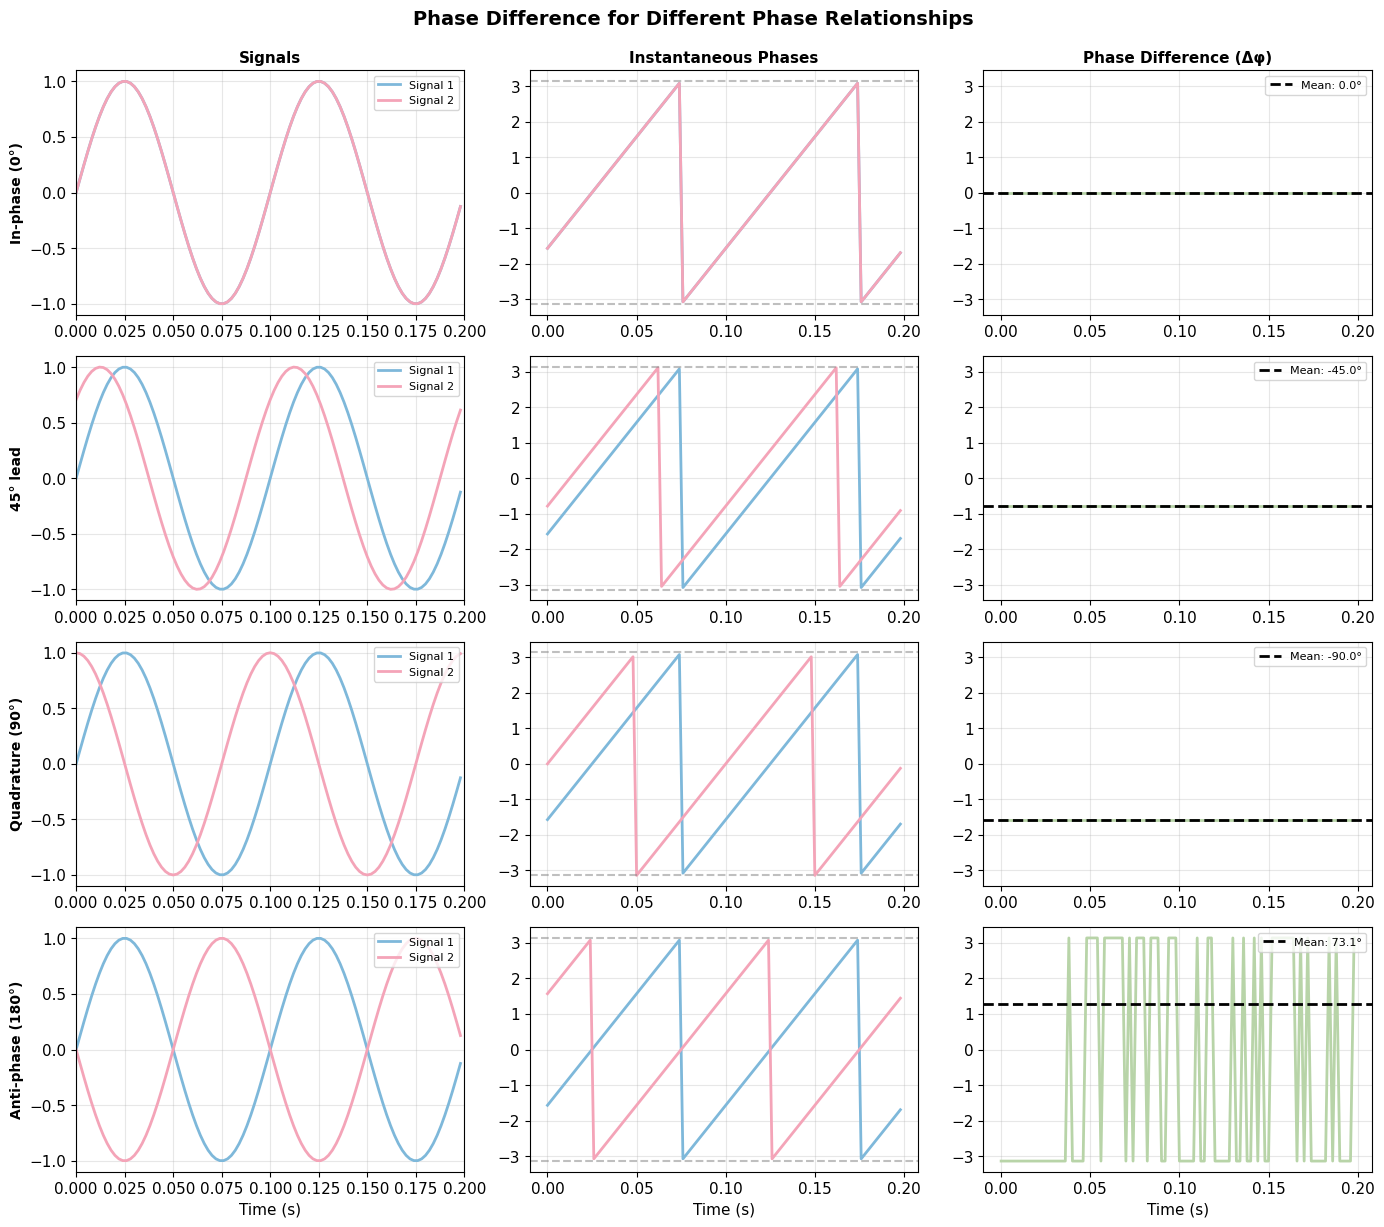


📊 Key Observations:
• In-phase: Δφ ≈ 0 (peaks align)
• 45° lead: Δφ ≈ π/4 (signal 2 slightly ahead)
• Quadrature: Δφ ≈ π/2 (signal 2 at peak when signal 1 crosses zero)
• Anti-phase: Δφ ≈ π or -π (peaks opposite)


In [3]:
# ============================================================================
# VISUALIZATION 1: Phase Difference for Different Phase Relationships
# ============================================================================

# Create time vector
fs = 500  # Sampling frequency
duration = 2  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 10  # 10 Hz oscillation

# Create signals with different phase relationships
phase_shifts = [0, np.pi/4, np.pi/2, np.pi]
shift_names = ['In-phase (0°)', '45° lead', 'Quadrature (90°)', 'Anti-phase (180°)']

fig, axes = plt.subplots(4, 3, figsize=(14, 12))

for i, (shift, name) in enumerate(zip(phase_shifts, shift_names)):
    # Create two signals
    signal1 = np.sin(2 * np.pi * freq * t)
    signal2 = np.sin(2 * np.pi * freq * t + shift)
    
    # Extract phases
    phase1 = extract_phase(signal1)
    phase2 = extract_phase(signal2)
    
    # Calculate phase difference
    diff = phase_difference(phase1, phase2)
    
    # Plot signals
    axes[i, 0].plot(t[:100], signal1[:100], color=COLORS["signal_1"], linewidth=2, label='Signal 1')
    axes[i, 0].plot(t[:100], signal2[:100], color=COLORS["signal_2"], linewidth=2, label='Signal 2')
    axes[i, 0].set_ylabel(name, fontsize=10, fontweight='bold')
    axes[i, 0].legend(loc='upper right', fontsize=8)
    axes[i, 0].set_xlim(0, 0.2)
    if i == 0:
        axes[i, 0].set_title('Signals', fontsize=11, fontweight='bold')
    if i == 3:
        axes[i, 0].set_xlabel('Time (s)')
    
    # Plot phases
    axes[i, 1].plot(t[:100], phase1[:100], color=COLORS["signal_1"], linewidth=2)
    axes[i, 1].plot(t[:100], phase2[:100], color=COLORS["signal_2"], linewidth=2)
    axes[i, 1].set_ylim(-np.pi - 0.3, np.pi + 0.3)
    axes[i, 1].axhline(np.pi, color='gray', linestyle='--', alpha=0.5)
    axes[i, 1].axhline(-np.pi, color='gray', linestyle='--', alpha=0.5)
    if i == 0:
        axes[i, 1].set_title('Instantaneous Phases', fontsize=11, fontweight='bold')
    if i == 3:
        axes[i, 1].set_xlabel('Time (s)')
    
    # Plot phase difference
    axes[i, 2].plot(t[:100], diff[:100], color=COLORS["signal_3"], linewidth=2)
    axes[i, 2].axhline(np.mean(diff), color='black', linestyle='--', linewidth=2, 
                        label=f'Mean: {np.degrees(np.mean(diff)):.1f}°')
    axes[i, 2].set_ylim(-np.pi - 0.3, np.pi + 0.3)
    axes[i, 2].legend(loc='upper right', fontsize=8)
    if i == 0:
        axes[i, 2].set_title('Phase Difference (Δφ)', fontsize=11, fontweight='bold')
    if i == 3:
        axes[i, 2].set_xlabel('Time (s)')

plt.tight_layout()
plt.suptitle('Phase Difference for Different Phase Relationships', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n📊 Key Observations:")
print("• In-phase: Δφ ≈ 0 (peaks align)")
print("• 45° lead: Δφ ≈ π/4 (signal 2 slightly ahead)")
print("• Quadrature: Δφ ≈ π/2 (signal 2 at peak when signal 1 crosses zero)")
print("• Anti-phase: Δφ ≈ π or -π (peaks opposite)")

---

<a id="section-3-instantaneous-vs-average"></a>
## 3. Instantaneous vs Average Phase Difference

### Two Perspectives on Phase Relationships

1. **Instantaneous phase difference** $\Delta\phi(t)$: The phase difference at each moment in time
2. **Average phase difference** $\overline{\Delta\phi}$: The mean relationship over a time window

### Why the Distinction Matters

- **Instantaneous**: Shows moment-to-moment dynamics, useful for tracking changes
- **Average**: Summarizes the typical relationship, needed for connectivity metrics

### Computing Average Phase Difference

We use the **circular mean** from B02a:

$$\overline{\Delta\phi} = \arctan2\left(\frac{1}{N}\sum_{t=1}^{N}\sin(\Delta\phi(t)), \frac{1}{N}\sum_{t=1}^{N}\cos(\Delta\phi(t))\right)$$

### Consistency: The Key to Synchronization

Two signals can have the same **average** phase difference but very different **consistency**:

| Scenario | Average Δφ | Consistency (R) | Interpretation |
|----------|-----------|-----------------|----------------|
| Strong coupling | ~45° | 0.95 | Stable 45° relationship |
| Weak coupling | ~45° | 0.3 | Noisy, unreliable |
| No coupling | ~0° | 0.05 | Random, no relationship |

In [4]:
# ============================================================================
# FUNCTIONS: Circular Statistics for Phase Difference
# ============================================================================

def circular_mean(phases: NDArray[np.float64]) -> float:
    """
    Compute circular mean of phase values.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        Circular mean in radians [-π, π].
    """
    mean_x = np.mean(np.cos(phases))
    mean_y = np.mean(np.sin(phases))
    return np.arctan2(mean_y, mean_x)


def resultant_vector_length(phases: NDArray[np.float64]) -> float:
    """
    Compute resultant vector length (R) - measure of concentration.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        R value in [0, 1]. Higher = more concentrated.
    """
    mean_x = np.mean(np.cos(phases))
    mean_y = np.mean(np.sin(phases))
    return np.sqrt(mean_x**2 + mean_y**2)


print("✓ circular_mean() and resultant_vector_length() defined")

✓ circular_mean() and resultant_vector_length() defined


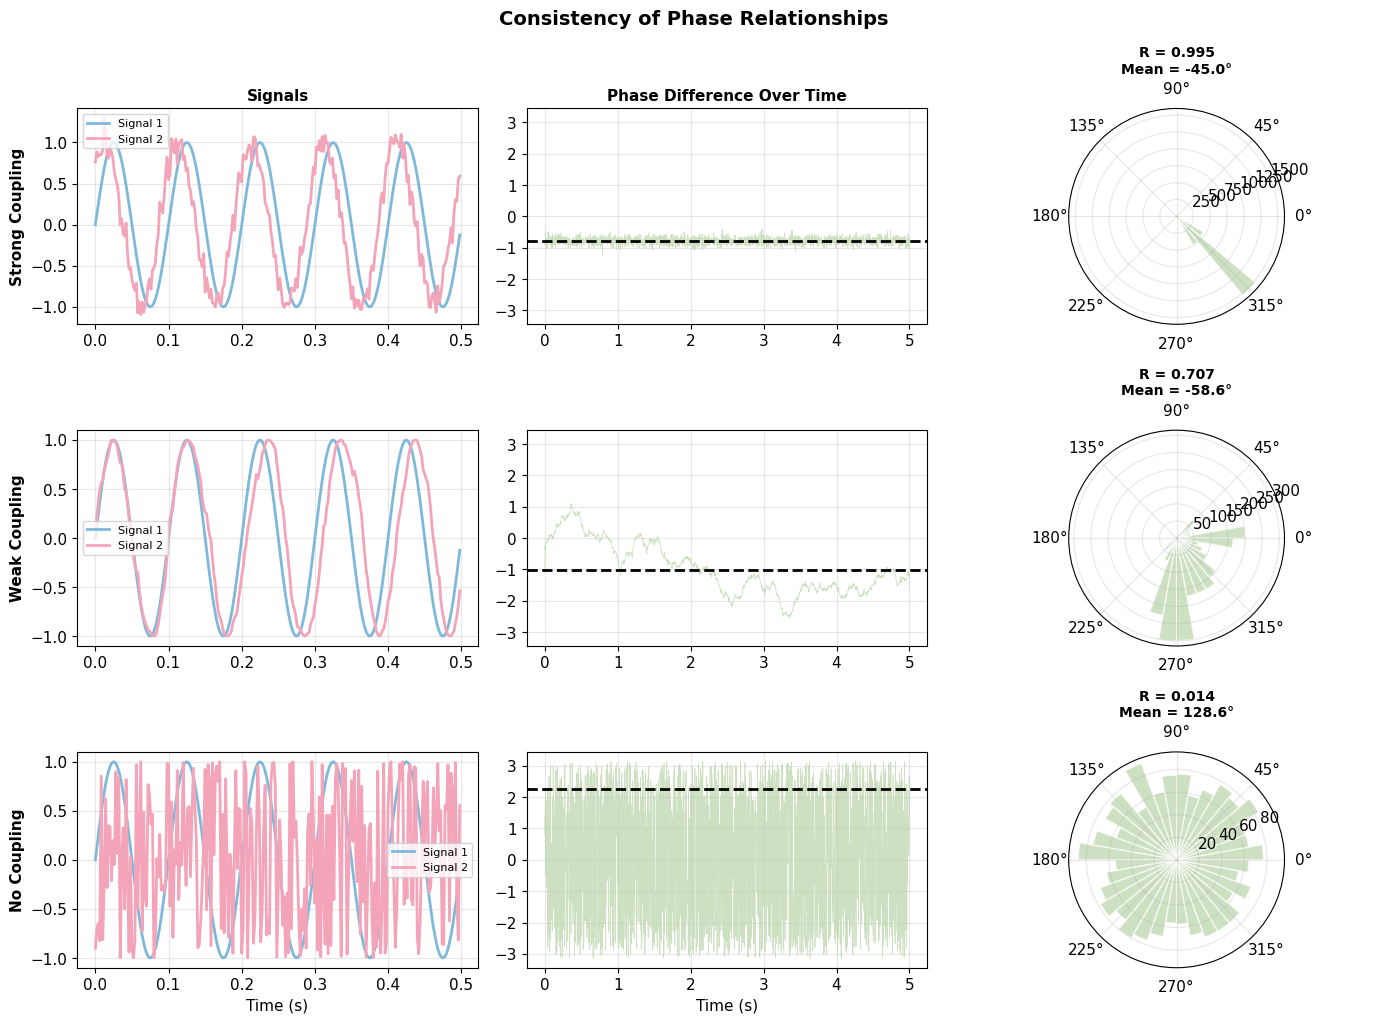


📊 Key Insight:
• R (consistency) is more important than average phase difference for synchronization
• High R = reliable coupling, Low R = no meaningful relationship


In [5]:
# ============================================================================
# VISUALIZATION 2: Consistent vs Inconsistent Phase Relationships
# ============================================================================

np.random.seed(42)
fs = 500
duration = 5
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 10

# Create reference signal
signal1 = np.sin(2 * np.pi * freq * t)
phase1 = extract_phase(signal1)

# Scenario 1: Strong coupling (consistent 45° relationship)
phase_shift_strong = np.pi/4 + np.random.normal(0, 0.1, len(t))  # Small jitter
signal2_strong = np.sin(2 * np.pi * freq * t + np.pi/4) + 0.1 * np.random.randn(len(t))

# Scenario 2: Weak coupling (noisy relationship)
phase_shift_weak = np.pi/4 + np.random.normal(0, 1.0, len(t))  # Large jitter
signal2_weak = np.sin(2 * np.pi * freq * t + np.cumsum(np.random.randn(len(t)) * 0.05))

# Scenario 3: No coupling (random phases)
signal2_none = np.sin(2 * np.pi * freq * t + np.random.uniform(-np.pi, np.pi, len(t)))

# Extract phases and compute differences
scenarios = [
    ('Strong Coupling', signal2_strong),
    ('Weak Coupling', signal2_weak),
    ('No Coupling', signal2_none)
]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, (name, sig2) in enumerate(scenarios):
    phase2 = extract_phase(sig2)
    diff = phase_difference(phase1, phase2)
    
    avg_diff = circular_mean(diff)
    R = resultant_vector_length(diff)
    
    # Plot signals (first 0.5s)
    idx = int(0.5 * fs)
    axes[i, 0].plot(t[:idx], signal1[:idx], color=COLORS["signal_1"], linewidth=2, label='Signal 1')
    axes[i, 0].plot(t[:idx], sig2[:idx], color=COLORS["signal_2"], linewidth=2, label='Signal 2')
    axes[i, 0].set_ylabel(name, fontsize=11, fontweight='bold')
    axes[i, 0].legend(fontsize=8)
    if i == 0:
        axes[i, 0].set_title('Signals', fontsize=11, fontweight='bold')
    if i == 2:
        axes[i, 0].set_xlabel('Time (s)')
    
    # Plot phase difference over time
    axes[i, 1].plot(t, diff, color=COLORS["signal_3"], linewidth=0.5, alpha=0.7)
    axes[i, 1].axhline(avg_diff, color='black', linestyle='--', linewidth=2)
    axes[i, 1].set_ylim(-np.pi - 0.3, np.pi + 0.3)
    if i == 0:
        axes[i, 1].set_title('Phase Difference Over Time', fontsize=11, fontweight='bold')
    if i == 2:
        axes[i, 1].set_xlabel('Time (s)')
    
    # Polar histogram of phase differences
    ax_polar = fig.add_subplot(3, 3, 3 * i + 3, projection='polar')
    bins = np.linspace(-np.pi, np.pi, 37)
    counts, edges = np.histogram(diff, bins=bins)
    width = 2 * np.pi / 36
    centers = (edges[:-1] + edges[1:]) / 2
    ax_polar.bar(centers, counts, width=width, color=COLORS["signal_3"], alpha=0.7, edgecolor='white')
    ax_polar.set_title(f'R = {R:.3f}\nMean = {np.degrees(avg_diff):.1f}°', fontsize=10, fontweight='bold')
    
    # Remove the placeholder axis
    axes[i, 2].axis('off')

plt.tight_layout()
plt.suptitle('Consistency of Phase Relationships', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n📊 Key Insight:")
print("• R (consistency) is more important than average phase difference for synchronization")
print("• High R = reliable coupling, Low R = no meaningful relationship")

---

<a id="section-4-visualizing-relationships"></a>
## 4. Visualizing Phase Relationships

### Common Visualization Methods

| Method | Shows | Best For |
|--------|-------|----------|
| **Phase-phase plot** | φ₁ vs φ₂ at each time point | Detecting phase locking patterns |
| **Phase difference histogram** | Distribution of Δφ | Quantifying coupling strength |
| **Relative phase on circle** | Δφ as points on unit circle | Intuitive view of consistency |
| **Time-varying phase difference** | Δφ(t) over time | Tracking dynamic coupling |

### The Phase-Phase Plot

A phase-phase plot shows $\phi_1$ on x-axis and $\phi_2$ on y-axis:
- **Diagonal line**: In-phase relationship
- **Parallel diagonal**: Constant phase lag
- **Scattered points**: No phase relationship
- **Multiple lines**: n:m phase locking

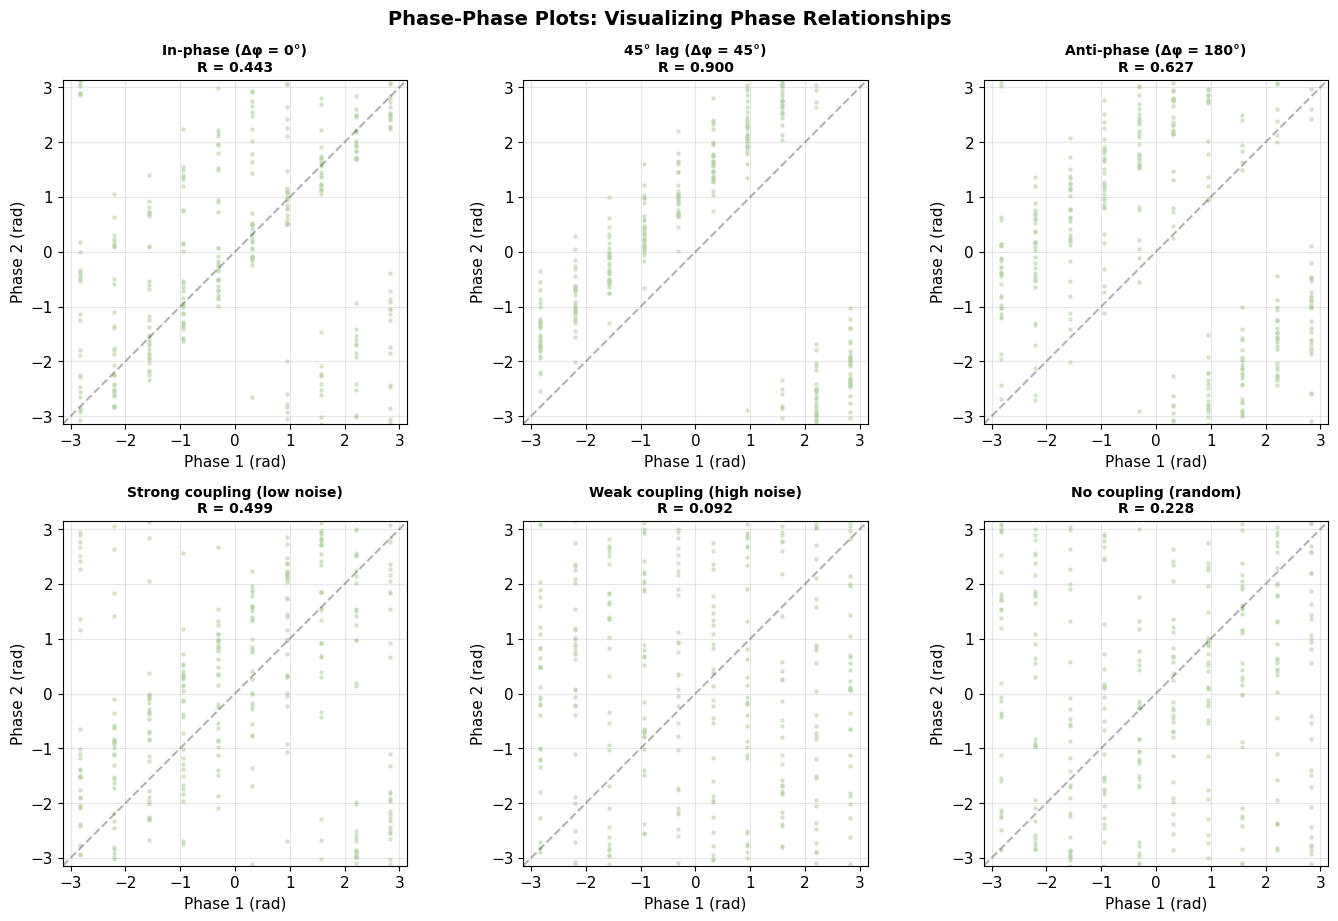


📊 Reading Phase-Phase Plots:
• Points along diagonal = in-phase
• Points along parallel line = constant lag
• Tight cluster = strong coupling (high R)
• Scattered points = weak/no coupling (low R)


In [6]:
# ============================================================================
# VISUALIZATION 3: Phase-Phase Plots for Different Coupling Scenarios
# ============================================================================

np.random.seed(42)
fs = 500
duration = 3
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 10

# Reference signal
signal1 = np.sin(2 * np.pi * freq * t)
phase1 = extract_phase(signal1)

# Different coupling scenarios
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

scenarios = [
    ('In-phase (Δφ = 0°)', 0, 0.05),
    ('45° lag (Δφ = 45°)', np.pi/4, 0.05),
    ('Anti-phase (Δφ = 180°)', np.pi, 0.05),
    ('Strong coupling (low noise)', np.pi/3, 0.1),
    ('Weak coupling (high noise)', np.pi/3, 0.8),
    ('No coupling (random)', 0, None)  # Special case
]

for ax, (name, shift, noise) in zip(axes.flat, scenarios):
    if noise is None:
        # No coupling - random phase
        signal2 = np.sin(2 * np.pi * freq * t + np.cumsum(np.random.randn(len(t)) * 0.3))
    else:
        # Add noise to phase
        noisy_phase = 2 * np.pi * freq * t + shift + np.cumsum(np.random.randn(len(t)) * noise)
        signal2 = np.sin(noisy_phase)
    
    phase2 = extract_phase(signal2)
    diff = phase_difference(phase1, phase2)
    R = resultant_vector_length(diff)
    
    # Phase-phase plot
    ax.scatter(phase1[::5], phase2[::5], s=5, alpha=0.5, c=COLORS["signal_3"])
    ax.plot([-np.pi, np.pi], [-np.pi, np.pi], 'k--', alpha=0.3, label='In-phase line')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel('Phase 1 (rad)')
    ax.set_ylabel('Phase 2 (rad)')
    ax.set_title(f'{name}\nR = {R:.3f}', fontsize=10, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase-Phase Plots: Visualizing Phase Relationships', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n📊 Reading Phase-Phase Plots:")
print("• Points along diagonal = in-phase")
print("• Points along parallel line = constant lag")
print("• Tight cluster = strong coupling (high R)")
print("• Scattered points = weak/no coupling (low R)")

---

<a id="section-5-phase-locking-preview"></a>
## 5. Phase Locking: A Preview

### From R to PLV

We've seen that **R** (resultant vector length) measures how consistently phase differences cluster around their mean. This is exactly the intuition behind the **Phase Locking Value (PLV)**!

### PLV Definition

$$PLV = \left| \frac{1}{N} \sum_{t=1}^{N} e^{i\Delta\phi(t)} \right| = R(\Delta\phi)$$

The PLV is simply the **R value of the phase difference time series**:
- **PLV = 1**: Perfect phase locking (constant Δφ)
- **PLV = 0**: No phase locking (uniform Δφ distribution)
- **PLV ∈ (0,1)**: Partial phase locking

### Why PLV Works

| Property | Explanation |
|----------|-------------|
| **Ignores amplitude** | Only uses phase information |
| **Normalized** | Always between 0 and 1 |
| **Symmetric** | PLV(A,B) = PLV(B,A) |
| **Phase-difference agnostic** | Detects both in-phase and anti-phase coupling |

In [7]:
# ============================================================================
# FUNCTION: Phase Locking Value (Preview)
# ============================================================================

def plv(phase1: NDArray[np.float64], phase2: NDArray[np.float64]) -> float:
    """
    Compute Phase Locking Value between two phase time series.
    
    PLV = |mean(exp(i * (phase1 - phase2)))|
    
    Parameters
    ----------
    phase1 : NDArray[np.float64]
        Phase of first signal in radians.
    phase2 : NDArray[np.float64]
        Phase of second signal in radians.
        
    Returns
    -------
    float
        PLV value in [0, 1]. Higher = stronger phase locking.
    """
    diff = phase1 - phase2
    return np.abs(np.mean(np.exp(1j * diff)))


print("✓ plv() defined")
print("\n📝 Note: This is a preview. Full PLV implementation in G01_phase_locking_value.ipynb")

✓ plv() defined

📝 Note: This is a preview. Full PLV implementation in G01_phase_locking_value.ipynb


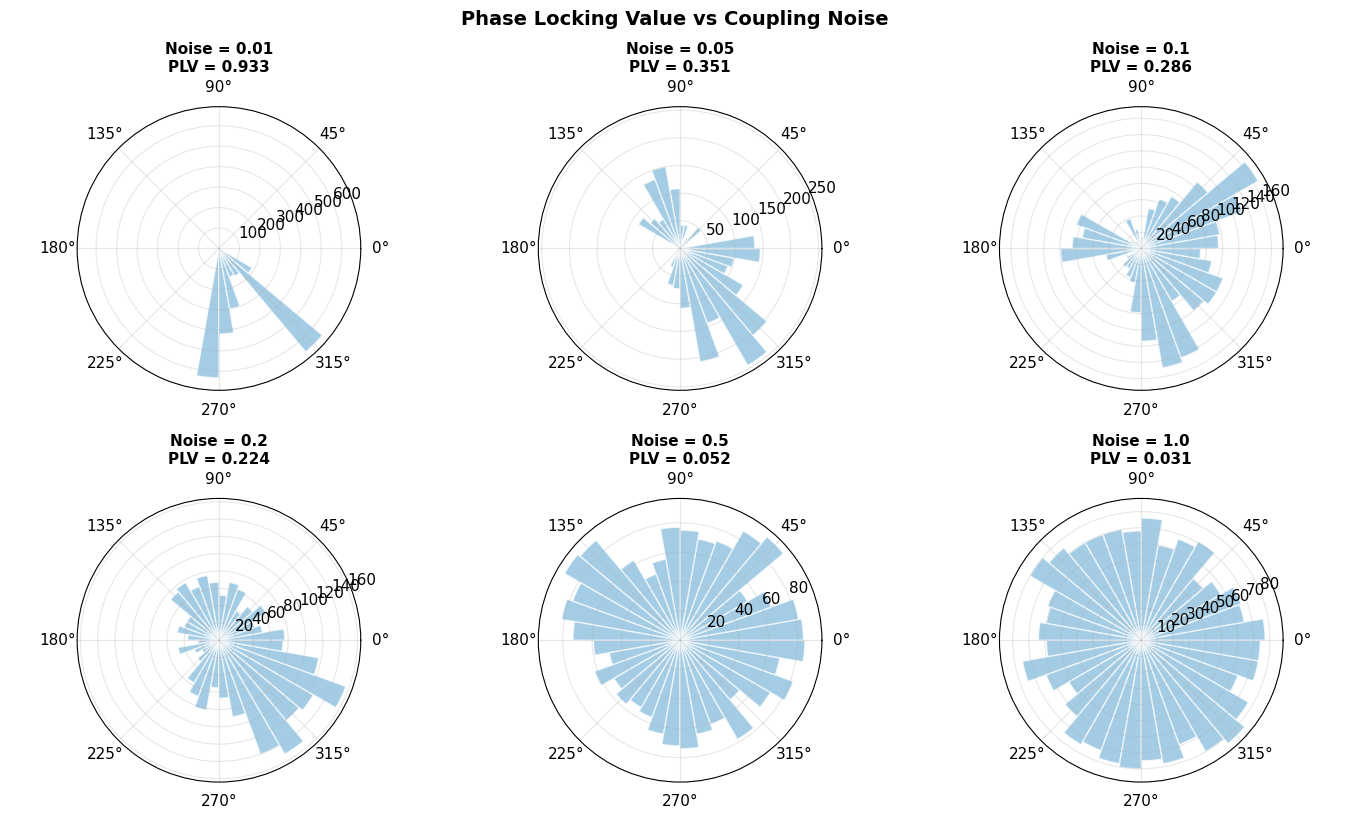

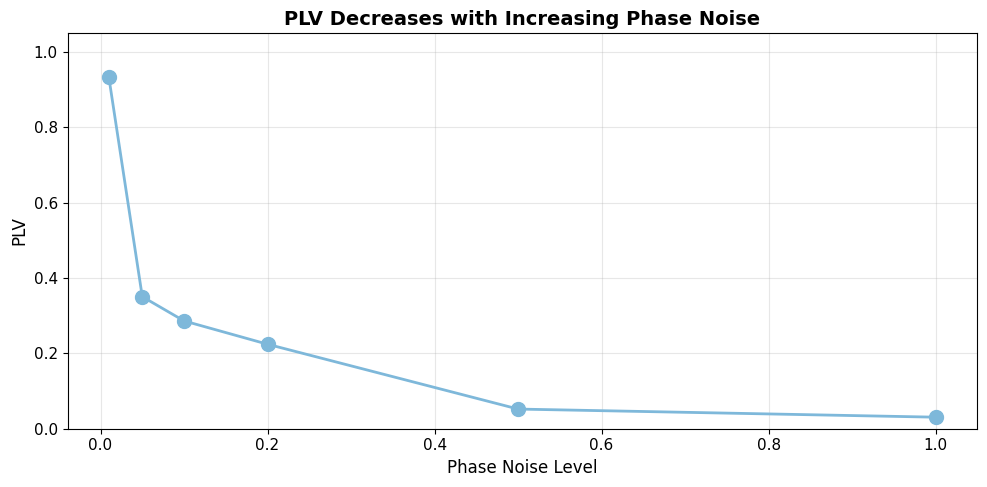


📊 Key Insight:
• PLV quantifies the consistency of phase relationships
• High noise → scattered phase differences → low PLV
• Low noise → concentrated phase differences → high PLV


In [8]:
# ============================================================================
# VISUALIZATION 4: PLV for Different Coupling Strengths
# ============================================================================

np.random.seed(42)
fs = 500
duration = 5
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 10

# Reference signal
signal1 = np.sin(2 * np.pi * freq * t)
phase1 = extract_phase(signal1)

# Create signals with varying coupling strength
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
plv_values = []

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, noise in zip(axes.flat, noise_levels):
    # Create coupled signal with noise
    noisy_phase = 2 * np.pi * freq * t + np.pi/4 + np.cumsum(np.random.randn(len(t)) * noise)
    signal2 = np.sin(noisy_phase)
    phase2 = extract_phase(signal2)
    
    # Calculate PLV
    plv_val = plv(phase1, phase2)
    plv_values.append(plv_val)
    
    # Calculate phase difference
    diff = phase_difference(phase1, phase2)
    
    # Polar histogram
    bins = np.linspace(-np.pi, np.pi, 37)
    counts, edges = np.histogram(diff, bins=bins)
    width = 2 * np.pi / 36
    centers = (edges[:-1] + edges[1:]) / 2
    
    ax_polar = fig.add_subplot(2, 3, list(axes.flat).index(ax) + 1, projection='polar')
    ax_polar.bar(centers, counts, width=width, color=COLORS["signal_1"], alpha=0.7, edgecolor='white')
    ax_polar.set_title(f'Noise = {noise}\nPLV = {plv_val:.3f}', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.suptitle('Phase Locking Value vs Coupling Noise', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Plot PLV vs noise
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(noise_levels, plv_values, 'o-', color=COLORS["signal_1"], linewidth=2, markersize=10)
ax.set_xlabel('Phase Noise Level', fontsize=12)
ax.set_ylabel('PLV', fontsize=12)
ax.set_title('PLV Decreases with Increasing Phase Noise', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Key Insight:")
print("• PLV quantifies the consistency of phase relationships")
print("• High noise → scattered phase differences → low PLV")
print("• Low noise → concentrated phase differences → high PLV")

---

<a id="section-6-application"></a>
## 6. Application: Two Coupled Oscillators

### A Hyperscanning Scenario

Imagine two participants in a hyperscanning experiment:
- Both have alpha oscillations (~10 Hz) in frontal regions
- During a cooperative task, their brain rhythms may synchronize
- We want to detect and quantify this inter-brain coupling

### Simulating Coupled Neural Oscillators

We'll create a simple model where:
1. Two oscillators have the same frequency
2. A coupling parameter controls how much they influence each other
3. Noise represents biological variability

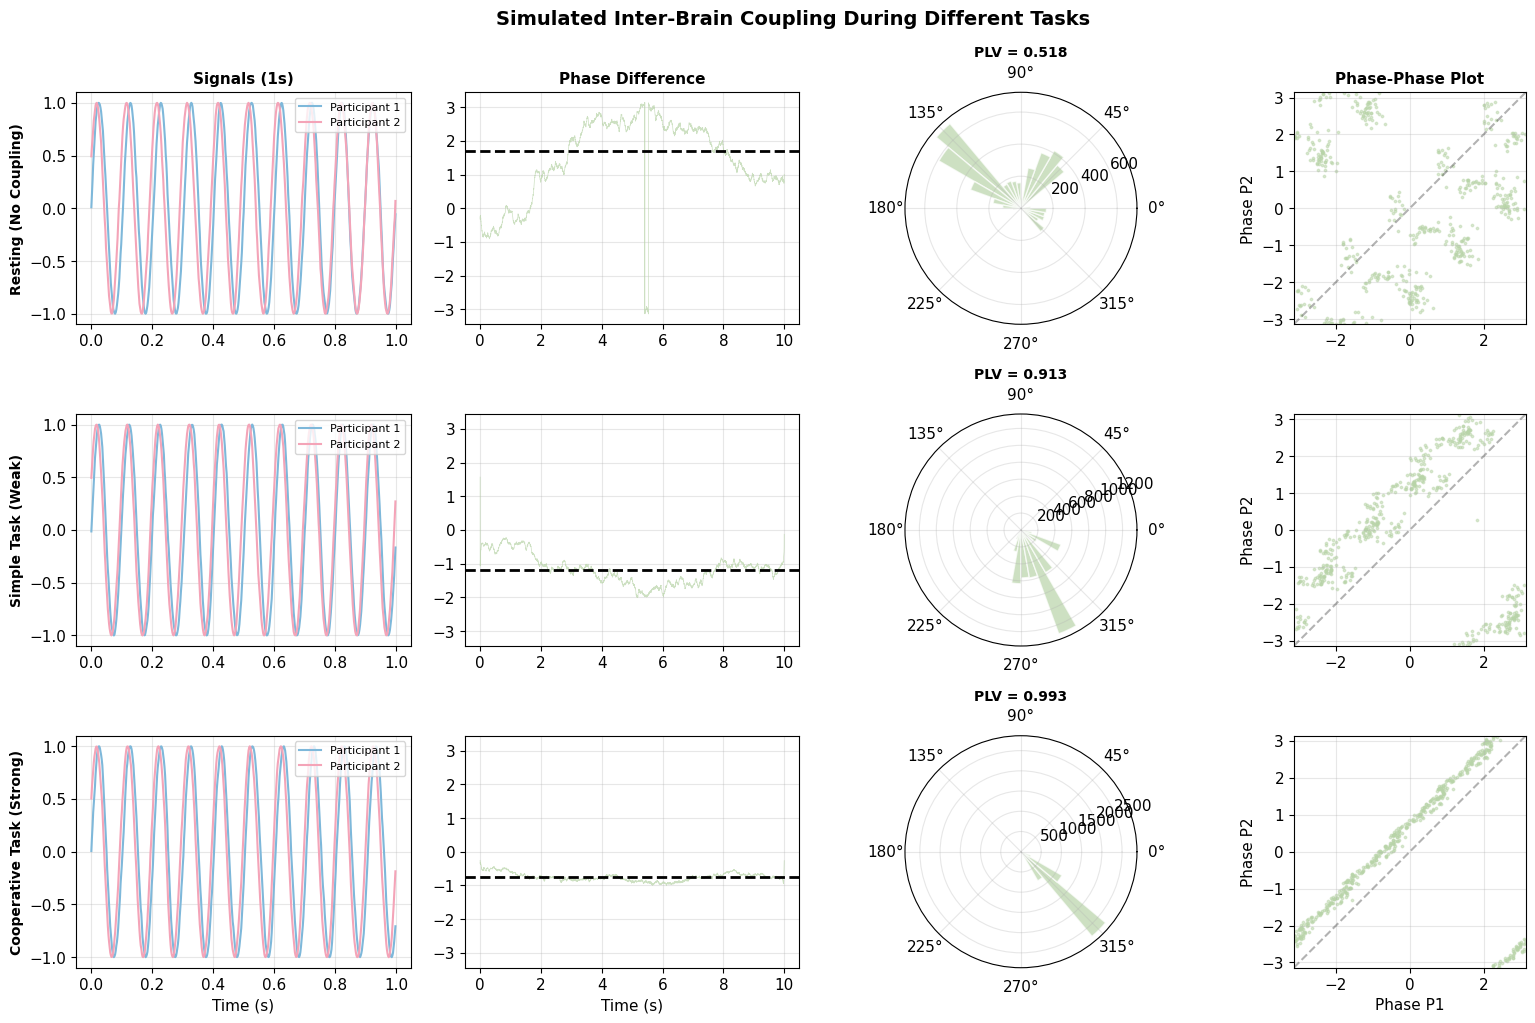


📊 Hyperscanning Interpretation:
• Resting: Independent oscillations → low PLV
• Simple task: Some coordination → moderate PLV
• Cooperative task: Strong coupling → high PLV

This is exactly what we measure in real hyperscanning experiments!


In [9]:
# ============================================================================
# VISUALIZATION 5: Simulated Hyperscanning - Coupled Brain Oscillators
# ============================================================================

np.random.seed(42)
fs = 500
duration = 10  # 10 seconds of "recording"
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 10  # Alpha frequency

# Simulate three conditions:
# 1. Resting (no coupling)
# 2. Simple task (weak coupling)  
# 3. Cooperative task (strong coupling)

conditions = [
    ('Resting (No Coupling)', 0.0),
    ('Simple Task (Weak)', 0.3),
    ('Cooperative Task (Strong)', 0.8)
]

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

for i, (condition_name, coupling) in enumerate(conditions):
    # Generate two oscillators with coupling
    # Participant 1: reference oscillator
    phase_drift_1 = np.cumsum(np.random.randn(len(t)) * 0.02)
    signal_p1 = np.sin(2 * np.pi * freq * t + phase_drift_1)
    
    # Participant 2: coupled to participant 1
    independent_drift = np.cumsum(np.random.randn(len(t)) * 0.02)
    coupled_component = phase_drift_1 * coupling
    phase_drift_2 = coupled_component + independent_drift * (1 - coupling)
    signal_p2 = np.sin(2 * np.pi * freq * t + phase_drift_2 + np.pi/6)  # Slight lag
    
    # Extract phases
    phase_p1 = extract_phase(signal_p1)
    phase_p2 = extract_phase(signal_p2)
    diff = phase_difference(phase_p1, phase_p2)
    
    # Calculate PLV
    plv_val = plv(phase_p1, phase_p2)
    
    # Plot 1: Signals (first 1 second)
    idx = int(1 * fs)
    axes[i, 0].plot(t[:idx], signal_p1[:idx], color=COLORS["signal_1"], linewidth=1.5, label='Participant 1')
    axes[i, 0].plot(t[:idx], signal_p2[:idx], color=COLORS["signal_2"], linewidth=1.5, label='Participant 2')
    axes[i, 0].set_ylabel(condition_name, fontsize=10, fontweight='bold')
    axes[i, 0].legend(fontsize=8, loc='upper right')
    if i == 0:
        axes[i, 0].set_title('Signals (1s)', fontsize=11, fontweight='bold')
    if i == 2:
        axes[i, 0].set_xlabel('Time (s)')
    
    # Plot 2: Phase difference over time
    axes[i, 1].plot(t, diff, color=COLORS["signal_3"], linewidth=0.5, alpha=0.7)
    axes[i, 1].axhline(circular_mean(diff), color='black', linestyle='--', linewidth=2)
    axes[i, 1].set_ylim(-np.pi - 0.3, np.pi + 0.3)
    if i == 0:
        axes[i, 1].set_title('Phase Difference', fontsize=11, fontweight='bold')
    if i == 2:
        axes[i, 1].set_xlabel('Time (s)')
    
    # Plot 3: Polar histogram
    ax_polar = fig.add_subplot(3, 4, 4*i + 3, projection='polar')
    bins = np.linspace(-np.pi, np.pi, 37)
    counts, edges = np.histogram(diff, bins=bins)
    width = 2 * np.pi / 36
    centers = (edges[:-1] + edges[1:]) / 2
    ax_polar.bar(centers, counts, width=width, color=COLORS["signal_3"], alpha=0.7, edgecolor='white')
    ax_polar.set_title(f'PLV = {plv_val:.3f}', fontsize=10, fontweight='bold')
    axes[i, 2].axis('off')
    
    # Plot 4: Phase-phase plot
    axes[i, 3].scatter(phase_p1[::10], phase_p2[::10], s=3, alpha=0.5, c=COLORS["signal_3"])
    axes[i, 3].plot([-np.pi, np.pi], [-np.pi, np.pi], 'k--', alpha=0.3)
    axes[i, 3].set_xlim(-np.pi, np.pi)
    axes[i, 3].set_ylim(-np.pi, np.pi)
    axes[i, 3].set_aspect('equal')
    if i == 0:
        axes[i, 3].set_title('Phase-Phase Plot', fontsize=11, fontweight='bold')
    if i == 2:
        axes[i, 3].set_xlabel('Phase P1')
    axes[i, 3].set_ylabel('Phase P2')

plt.tight_layout()
plt.suptitle('Simulated Inter-Brain Coupling During Different Tasks', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n📊 Hyperscanning Interpretation:")
print("• Resting: Independent oscillations → low PLV")
print("• Simple task: Some coordination → moderate PLV")
print("• Cooperative task: Strong coupling → high PLV")
print("\nThis is exactly what we measure in real hyperscanning experiments!")

---

<a id="section-7-exercises"></a>
## 7. Exercises

### 🎯 Exercise 1: Phase Difference Interpretation

**Task:** Given two signals, calculate and interpret their phase relationship.

1. Create two 10 Hz signals with a 90° phase difference
2. Extract phases and compute phase difference
3. Calculate PLV and circular mean of phase difference
4. What type of relationship does this represent?

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Create signals with 90° phase difference
fs = 500
duration = 2
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

signal1 = np.sin(2 * np.pi * 10 * t)
signal2 = np.sin(2 * np.pi * 10 * t + np.pi/2)  # 90° = π/2

# Extract phases
phase1 = extract_phase(signal1)
phase2 = extract_phase(signal2)

# Compute phase difference
diff = phase_difference(phase1, phase2)

# Calculate statistics
mean_diff = circular_mean(diff)
plv_val = plv(phase1, phase2)

print(f"Mean phase difference: {np.degrees(mean_diff):.1f}°")
print(f"PLV: {plv_val:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Signals
axes[0].plot(t[:100], signal1[:100], color=COLORS["signal_1"], label='Signal 1')
axes[0].plot(t[:100], signal2[:100], color=COLORS["signal_2"], label='Signal 2')
axes[0].set_xlabel('Time (s)')
axes[0].set_title('Signals in Quadrature (90° apart)')
axes[0].legend()

# Phase difference histogram
axes[1].hist(diff, bins=36, color=COLORS["signal_3"], alpha=0.7, edgecolor='white')
axes[1].axvline(mean_diff, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Phase difference (rad)')
axes[1].set_title(f'Phase Difference Distribution\nPLV = {plv_val:.3f}')

plt.tight_layout()
plt.show()

print("\n📝 Interpretation:")
print("• 90° phase difference = quadrature relationship")
print("• Signal 2 peaks when Signal 1 crosses zero")
print("• PLV ≈ 1 indicates perfect phase locking")
print("• This is common between sine and cosine components")
```

</details>

---

### 🎯 Exercise 2: Detecting Coupling Changes

**Task:** Simulate a scenario where coupling changes over time and detect it.

1. Create a 10-second signal where coupling increases at t=5s
2. Compute time-varying PLV using 1-second sliding windows
3. Plot PLV over time
4. Can you detect when coupling changed?

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
np.random.seed(42)
fs = 500
duration = 10
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Reference signal
signal1 = np.sin(2 * np.pi * 10 * t + np.cumsum(np.random.randn(len(t)) * 0.01))

# Signal 2: weak coupling first 5s, strong coupling after
coupling = np.where(t < 5, 0.1, 0.9)  # Step change at t=5s
phase_noise = np.cumsum(np.random.randn(len(t)) * 0.05)
signal2 = np.sin(2 * np.pi * 10 * t + phase_noise * (1 - coupling))

# Extract phases
phase1 = extract_phase(signal1)
phase2 = extract_phase(signal2)

# Compute time-varying PLV (1-second windows)
window_size = int(1 * fs)  # 1 second
step_size = int(0.1 * fs)  # 100 ms step
plv_times = []
plv_values = []

for start in range(0, len(t) - window_size, step_size):
    end = start + window_size
    window_plv = plv(phase1[start:end], phase2[start:end])
    plv_times.append(t[start + window_size // 2])
    plv_values.append(window_plv)

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Signals
axes[0].plot(t, signal1, color=COLORS["signal_1"], alpha=0.7, label='Signal 1')
axes[0].plot(t, signal2, color=COLORS["signal_2"], alpha=0.7, label='Signal 2')
axes[0].axvline(5, color='red', linestyle='--', linewidth=2, label='Coupling change')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Two Signals with Coupling Change at t=5s')
axes[0].legend()

# Phase difference
diff = phase_difference(phase1, phase2)
axes[1].plot(t, diff, color=COLORS["signal_3"], alpha=0.5)
axes[1].axvline(5, color='red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Phase diff (rad)')
axes[1].set_title('Instantaneous Phase Difference')

# Time-varying PLV
axes[2].plot(plv_times, plv_values, color=COLORS["signal_1"], linewidth=2)
axes[2].axvline(5, color='red', linestyle='--', linewidth=2, label='True change')
axes[2].axhline(0.5, color='gray', linestyle=':', alpha=0.5)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('PLV')
axes[2].set_title('Time-Varying PLV (1s windows)')
axes[2].set_ylim(0, 1)
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n📝 Interpretation:")
print("• Before t=5s: Low PLV (weak coupling)")
print("• After t=5s: High PLV (strong coupling)")
print("• Time-varying PLV reveals dynamic changes in synchronization")
```

</details>

---

<a id="section-8-summary"></a>
## 8. Summary

### Key Concepts

| Concept | Description | Key Formula |
|---------|-------------|-------------|
| **Phase difference** | Δφ = φ₁ - φ₂, wrapped to [-π, π] | `np.angle(np.exp(1j * (phase1 - phase2)))` |
| **Average phase difference** | Circular mean of Δφ | `arctan2(mean(sin(Δφ)), mean(cos(Δφ)))` |
| **Phase Locking Value (PLV)** | Consistency of phase difference | `|mean(exp(i·Δφ))|` |
| **Phase-phase plot** | φ₁ vs φ₂ visualization | Diagonal = in-phase |

### Functions Reference

```python
# Phase difference
diff = phase_difference(phase1, phase2)  # Wrapped to [-π, π]

# Circular statistics on phase difference
avg_diff = circular_mean(diff)      # Average relationship
R = resultant_vector_length(diff)   # Consistency = PLV

# Phase Locking Value
plv_value = plv(phase1, phase2)     # Equivalent to R of phase difference
```

### Connecting to Connectivity Metrics

| This Notebook | Full Metric (Part 2) |
|---------------|---------------------|
| PLV preview | [G01: Phase Locking Value](../../02_connectivity_metrics/G_phase_based/G01_phase_locking_value.ipynb) |
| Phase difference | [G02: Phase Lag Index](../../02_connectivity_metrics/G_phase_based/G02_phase_lag_index.ipynb) |
| Consistency measure | [G03: wPLI](../../02_connectivity_metrics/G_phase_based/G03_weighted_phase_lag_index.ipynb) |

### ⚠️ Common Pitfalls

1. **Forgetting to wrap** phase difference → values outside [-π, π]
2. **Confusing PLV with correlation** → PLV ignores amplitude
3. **Not filtering first** → PLV is frequency-specific (filter to band of interest)
4. **Sample size bias** → PLV can be inflated with few samples

---

<a id="section-9-external-resources"></a>
## 9. External Resources

### 📚 Scientific References

- **Lachaux et al. (1999)** - *Measuring phase synchrony in brain signals* - Original PLV paper
- **Pikovsky et al. (2001)** - *Synchronization: A Universal Concept in Nonlinear Sciences* - Theoretical foundations
- **Vinck et al. (2011)** - *An improved index of phase-synchronization* - PLI and wPLI

### 🎧 NotebookLM Resources

*Resources will be added after NotebookLM content creation:*

- [📺 Video Overview](URL) - Video overview of phase relationships concepts
- [📝 Quiz](URL) - Test your understanding of phase synchronization
- [🗂️ Flashcards](URL) - Review key concepts

### 🔗 Online Resources

- [Scholarpedia: Phase Synchronization](http://www.scholarpedia.org/article/Phase_synchronization)
- [MNE-Python: Connectivity Analysis](https://mne.tools/stable/auto_tutorials/connectivity/index.html)

---

<a id="section-10-discussion"></a>
## 10. Discussion Questions

1. **In-phase vs Anti-phase**  
   Two brain regions show PLV = 0.9 with an average phase difference of 180°. Are they coupled? What might this anti-phase relationship mean functionally?

2. **PLV limitations**  
   A researcher finds PLV = 0.8 between frontal and occipital regions. What additional checks should they perform before concluding these regions are functionally coupled?

3. **Frequency matters**  
   Why is it important to filter signals to a specific frequency band before computing PLV? What would happen if you computed PLV on broadband (unfiltered) signals?

4. **Time resolution trade-off**  
   In Exercise 2, we used 1-second windows for time-varying PLV. How would shorter (0.2s) or longer (3s) windows change the results? What's the trade-off?

5. **From PLV to hyperscanning**  
   In a hyperscanning experiment, you find PLV = 0.6 between two participants during cooperation. How would you determine if this value is statistically significant?

---

**Series complete!** You now understand how to work with phase:
- [B02a](B02a_circular_statistics.ipynb): Circular statistics for single signals
- [B02b](B02b_phase_relationships.ipynb): Phase relationships between signals (this notebook)

**Next:** [B03: Amplitude Envelope](B03_amplitude_envelope.ipynb) or jump to [G01: Phase Locking Value](../../02_connectivity_metrics/G_phase_based/G01_phase_locking_value.ipynb) for the full PLV implementation.